# Outline
  
## 1. Advance Filters
   1.1.   Bilateral filter

  1.2.  Conservative Filter

  1.3 Crimmins complementary culling algorithm

## 2. Transform Domain Filtering
2.1.  	Image filtering using DFT

2.2  Low pass filter in transform domain

2.3  High pass filter in transform domain

## 3. Morphological Filters
3.1   Image Dilation

3.2  Erosion

In [33]:
#clear previous variaables
globals().clear()
#loading All dependencies
import numpy as np
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from skimage import color
from PIL import Image
import matplotlib.pylab as plt
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
#Mounting Google Drive to read files
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Add Noise to an image


In [34]:
import random
def add_noise(im):

    # Getting the dimensions of the image
    row,col = im.shape

    # Randomly pick some pixels in the
    # image for coloring them white
    # Pick a random number between 100 and 10000
    number_of_pixels = random.randint(100, 10000)
    for i in range(number_of_pixels):

        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)

        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)

        # Color that pixel to white
        im[y_coord][x_coord] = 255

    # Randomly pick some pixels in
    # the image for coloring them black
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300 , 10000)
    for i in range(number_of_pixels):

        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)

        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)

        # Color that pixel to black
        im[y_coord][x_coord] = 0

    return im



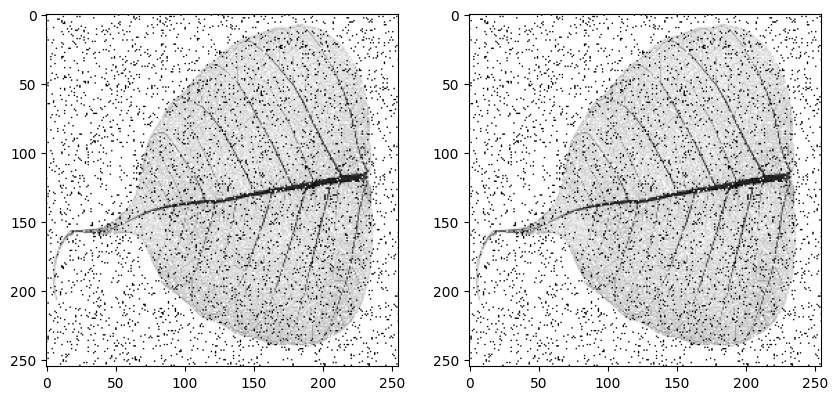

In [35]:
# salt-and-pepper noise can
# be applied only to grayscale images
# Reading the color image in grayscale image
img_o = cv.imread('/content/drive/MyDrive/Colab Notebooks/leaf.jpg', cv.IMREAD_GRAYSCALE)
img_o = cv.resize(img_o, (255, 255))
img_n=add_noise(img_o)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 5))
ax0.imshow(img_o, cmap='gray');
ax1.imshow(img_n, cmap='gray');

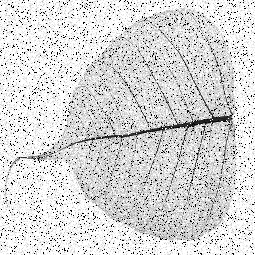

In [36]:
import numpy as np
from skimage.util import random_noise

# Add salt-and-pepper noise to the image.
#noise_img = random_noise(img_o, mode='s&p',amount=0.3)
# Add Gaussian noise
#noise_img = random_noise(img_o, mode='gaussian')
# Add Gaussian noise
noise_img = random_noise(img_o, mode='speckle')
# The above function returns a floating-point image
# on the range [0, 1], thus we changed it to 'uint8'
# and from [0,255]
noise_img = np.array(255*noise_img, dtype = 'uint8')

# Display the noise image
cv2_imshow(noise_img)

### 1.1 Bilateral Filtering
The previous filters blur the image, but the bilateral filter tends to blur the image preserving the edges between the objects. In addition, while blurring the image, the bilateral filter considers the nearby pixel intensity values and considers whether the pixel is on edge or not; this makes the operation of this filter a bit slow.



KeyError: ignored

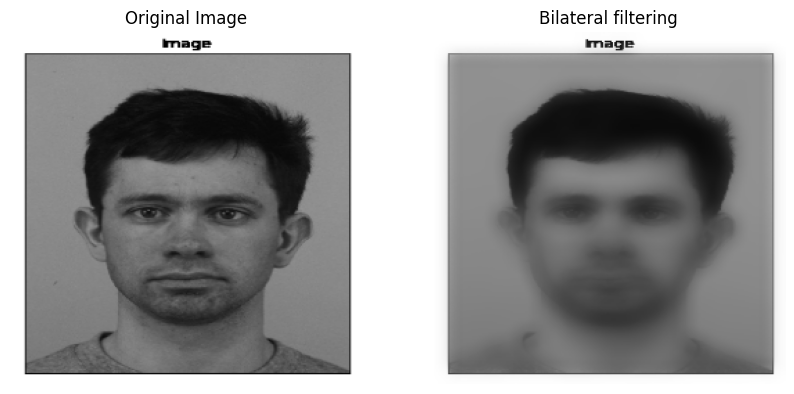

In [37]:
## bilateral filtering
img_o = cv.imread('/content/drive/MyDrive/Colab Notebooks/human.png', cv.IMREAD_GRAYSCALE)
img_o = cv.resize(img_o, (255, 255))
img = cv.cvtColor(img_o,cv.COLOR_BGR2RGB)
blur = cv.bilateralFilter(img,20,200,300)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 5))
ax0.imshow(img, cmap='gray'); ax0.axis('off');ax0.set_title('Original Image')
blur = cv.bilateralFilter(img,20,200,300)
ax1.imshow(blur, cmap='gray'); ax1.axis('off');ax1.set_title('Bilateral filtering')

### 1.2 Conservative Filtering
The conservative filters are preferred to remove salt and pepper noise. Determines the minimum intensity and maximum intensity within a neighborhood of a pixel. If the intensity of the center pixel is greater than the maximum value it is replaced by the maximum value. If it is less than the minimum value than it is replaced by the minimum value. The conservative filter preserves edges of the images but does not remove speckle noise.  the filter is not able to remove as much salt-and-pepper noise as a median filter (although it does preserve more detail.)

In [38]:
# first a conservative filter for grayscale images will be defined.
def conservative_smoothing_gray(data, filter_size):
    temp = []

    indexer = filter_size // 2

    new_image = data.copy()

    nrow, ncol = data.shape

    for i in range(nrow):

        for j in range(ncol):

            for k in range(i-indexer, i+indexer+1):

                for m in range(j-indexer, j+indexer+1):

                    if (k > -1) and (k < nrow):

                        if (m > -1) and (m < ncol):

                            temp.append(data[k,m])

            temp.remove(data[i,j])


            max_value = max(temp)

            min_value = min(temp)

            if data[i,j] > max_value:

                new_image[i,j] = max_value

            elif data[i,j] < min_value:

                new_image[i,j] = min_value

            temp =[]

    return new_image.copy()

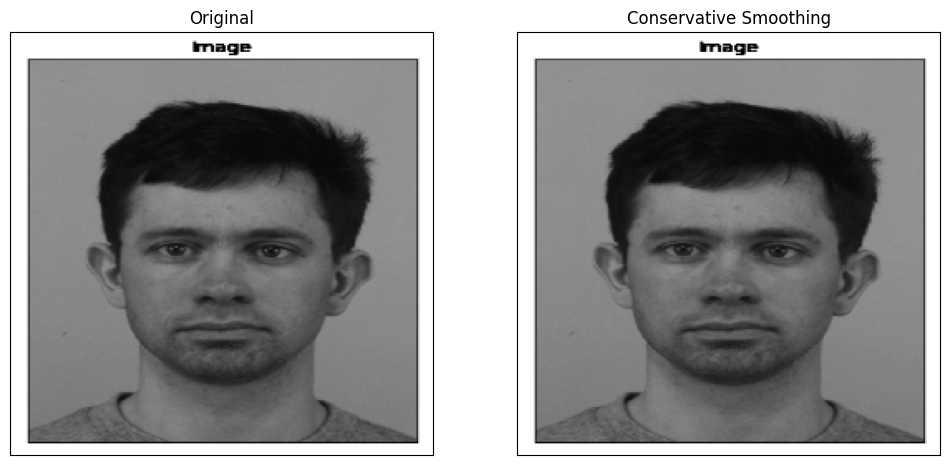

In [39]:
new_image = conservative_smoothing_gray(img_o,5)
plt.figure(figsize=(12,12))
plt.subplot(121), plt.imshow(img, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(new_image, cmap='gray'),plt.title('Conservative Smoothing')
plt.xticks([]), plt.yticks([])
plt.show()

### 1.3 Crimmins complementary culling algorithm
The Crimmins complementary culling algorithm is used to remove speckle noise and smooth the edges. It also reduces the intensity of salt and pepper noise. The algorithm compares the intensity of a pixel in a image with the intensities of its 8 neighbors. The algorithm considers 4 sets of neighbors (N-S, E-W, NW-SE, NE-SW.) Let a,b,c be three consecutive pixels (for example from E-S). Then the algorithm is:
For each iteration:

**a) Dark pixel adjustment: For each of the four directions**

1) Process whole image with: if a ≥ b+2 then b = b + 1

2) Process whole image with: if a > b and b ≤ c then b = b + 1

3) Process whole image with: if c > b and b ≤ a then b = b + 1

4) Process whole image with: if c ≥ b+2 then b = b + 1

**b) Light pixel adjustment: For each of the four directions**

1) Process whole image with: if a ≤ b — 2 then b = b — 1

2) Process whole image with: if a < b and b ≥ c then b = b — 1

3) Process whole image with: if c < b and b ≥ a then b = b — 1

4) Process whole image with: if c ≤ b — 2 then b = b — 1

In [40]:
def crimmins(data):
    new_image = data.copy()
    nrow = len(data)
    ncol = len(data[0])

    # Dark pixel adjustment

    # First Step
    # N-S
    for i in range(1, nrow):
        for j in range(ncol):
            if data[i-1,j] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(ncol-1):
            if data[i,j+1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow):
        for j in range(1, ncol):
            if data[i-1,j-1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    #NE-SW
    for i in range(1, nrow):
        for j in range(ncol-1):
            if data[i-1,j+1] >= (data[i,j] + 2):
                new_image[i,j] += 1
    data = new_image
    # Second Step
    # N-S
    for i in range(1, nrow-1):
        for j in range(ncol):
            if (data[i-1,j] > data[i,j]) and (data[i,j] <= data[i+1,j]):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j+1] > data[i,j]) and (data[i,j] <= data[i,j-1]):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i-1,j-1] > data[i,j]) and (data[i,j] <= data[i+1,j+1]):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i-1,j+1] > data[i,j]) and (data[i,j] <= data[i+1,j-1]):
                new_image[i,j] += 1
    data = new_image
    #Third Step
    # N-S
    for i in range(1, nrow-1):
        for j in range(ncol):
            if (data[i+1,j] > data[i,j]) and (data[i,j] <= data[i-1,j]):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j-1] > data[i,j]) and (data[i,j] <= data[i,j+1]):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i+1,j+1] > data[i,j]) and (data[i,j] <= data[i-1,j-1]):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(1, nrow-1):
        for j in range(1, ncol-1):
            if (data[i+1,j-1] > data[i,j]) and (data[i,j] <= data[i-1,j+1]):
                new_image[i,j] += 1
    data = new_image
    # Fourth Step
    # N-S
    for i in range(nrow-1):
        for j in range(ncol):
            if (data[i+1,j] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol):
            if (data[i,j-1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # NW-SE
    for i in range(nrow-1):
        for j in range(ncol-1):
            if (data[i+1,j+1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image
    # NE-SW
    for i in range(nrow-1):
        for j in range(1,ncol):
            if (data[i+1,j-1] >= (data[i,j]+2)):
                new_image[i,j] += 1
    data = new_image

    # Light pixel adjustment

    # First Step
    # N-S
    for i in range(1,nrow):
        for j in range(ncol):
            if (data[i-1,j] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(ncol-1):
            if (data[i,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow):
        for j in range(1,ncol):
            if (data[i-1,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow):
        for j in range(ncol-1):
            if (data[i-1,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # Second Step
    # N-S
    for i in range(1,nrow-1):
        for j in range(ncol):
            if (data[i-1,j] < data[i,j]) and (data[i,j] >= data[i+1,j]):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1, ncol-1):
            if (data[i,j+1] < data[i,j]) and (data[i,j] >= data[i,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i-1,j-1] < data[i,j]) and (data[i,j] >= data[i+1,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i-1,j+1] < data[i,j]) and (data[i,j] >= data[i+1,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # Third Step
    # N-S
    for i in range(1,nrow-1):
        for j in range(ncol):
            if (data[i+1,j] < data[i,j]) and (data[i,j] >= data[i-1,j]):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol-1):
            if (data[i,j-1] < data[i,j]) and (data[i,j] >= data[i,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i+1,j+1] < data[i,j]) and (data[i,j] >= data[i-1,j-1]):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(1,nrow-1):
        for j in range(1,ncol-1):
            if (data[i+1,j-1] < data[i,j]) and (data[i,j] >= data[i-1,j+1]):
                new_image[i,j] -= 1
    data = new_image
    # Fourth Step
    # N-S
    for i in range(nrow-1):
        for j in range(ncol):
            if (data[i+1,j] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # E-W
    for i in range(nrow):
        for j in range(1,ncol):
            if (data[i,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NW-SE
    for i in range(nrow-1):
        for j in range(ncol-1):
            if (data[i+1,j+1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    # NE-SW
    for i in range(nrow-1):
        for j in range(1,ncol):
            if (data[i+1,j-1] <= (data[i,j]-2)):
                new_image[i,j] -= 1
    data = new_image
    return new_image.copy()

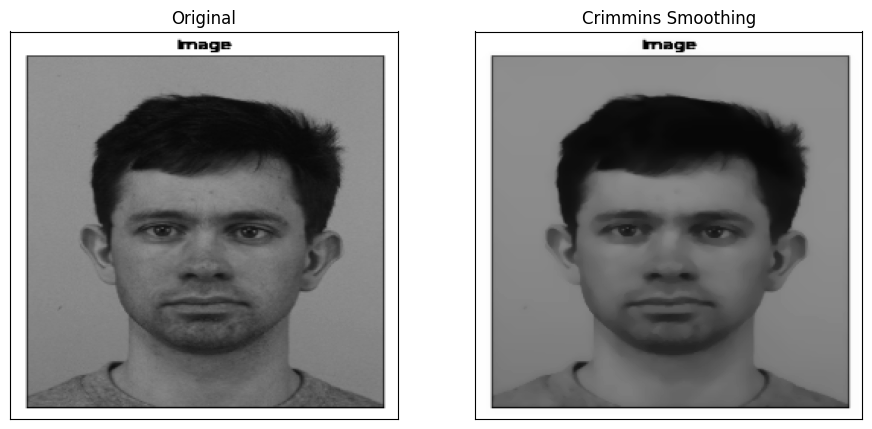

In [41]:
new_image = crimmins(img_o)
plt.figure(figsize=(11,6))
plt.subplot(121), plt.imshow(img_o, cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(new_image, cmap='gray'),plt.title('Crimmins Smoothing')
plt.xticks([]), plt.yticks([])
plt.show()

## 2. Transform Domain Filtering
When applying frequency filters to an image it is important to first convert the image to the frequency domain representation of the image.
### 2.1 Conversion to frequency domain
The Fourier transform (which decomposes a function into its sine and cosine components) can be applied to an image in order to obtain its frequency domain representation. The reason we are interested in an image’s frequency domain representation is that it is less expensive to apply frequency filters to an image in the frequency domain than it is to apply the filters in the spatial domain. This is due to the fact that each pixel in the frequency domain representation corresponds to a frequency rather than a location of the image.
The ‘dft’ function determines the discrete Fourier transform of an image. For a M x N image the two dimensional discrete Fourier transform is given by:

$F(r,c)=∑_{i=0}^{M-1}∑_{j=0}^{N-1}{f(i,j)e^{-2π(\frac{ki}{M}+\frac{lj}{N})}}$

where f is the image value in the spatial domain and F in its the frequency domain. The following is the formula for the inverse discrete Fourier transform (which converts an image from its frequency domain to the spatial domain):

$f(a,b)=\frac{1}{M×N}∑_{k=0}^{M-1}∑_{l=0}^{N-1}{f(k,l)e^{2π(\frac{ka}{M}+\frac{lb}{N})}}$


Once a frequency filter is applied to an image, the inverse Fourier transform can be used to convert the image back to the spatial domain.

### 2.2 Filter in Frequency Domain
Low pass filters and high pass filters are both frequency filters. The low pass filters preserves the lowest frequencies (that are below a threshold) which means it blurs the edges and removes speckle noise from the image in the spatial domain. The high pass filter preserves high frequencies which means it preserves edges.

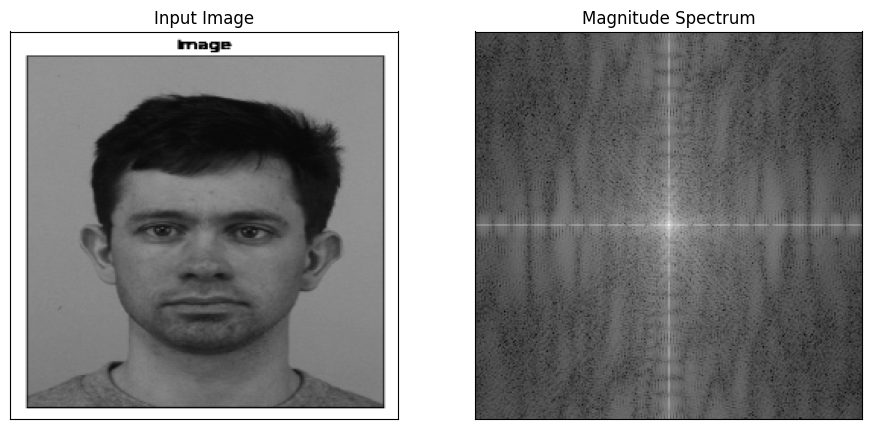

In [42]:
dft = cv.dft(np.float32(img_o),flags = cv.DFT_COMPLEX_OUTPUT)
# shift the zero-frequncy component to the center of the spectrum
dft_shift = np.fft.fftshift(dft)
# save image of the image in the fourier domain.
magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
# plot both images
plt.figure(figsize=(11,6))
plt.subplot(121),plt.imshow(img_o, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

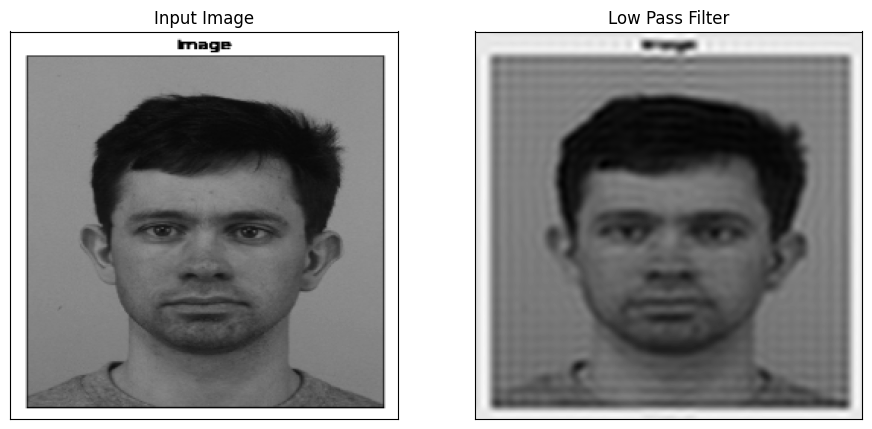

In [43]:
rows, cols = img_o.shape
crow,ccol = rows//2 , cols//2
# create a mask first, center square is 1, remaining all zeros for low pass
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1
# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0],img_back[:,:,1])
# plot both images
plt.figure(figsize=(11,6))
plt.subplot(121),plt.imshow(img_o, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Low Pass Filter'), plt.xticks([]), plt.yticks([])
plt.show()

## Morphological Filtering
Morphological filters are some simple operations based on image shape these are very useful for segmentation. These filters need two inputs: image and kernel, which decides the nature of the operation.
### Erosion
It is just like soil erosion; it erodes the boundary, it warns away the boundaries of foreground objects, i.e., tries to keep the foreground white. So the operation follows as the kernel slides over the image, and a pixel of the image is considered one only if all the pixels under the kernel are 1; otherwise, it is eroded.
### Dilation
It is just the opposite of erosion; here, the pixel is considered as one if at least one pixel under the kernel is one, so in this case, it increases the white region in the image. Dilation is also helpful in joining the broken part of an object.

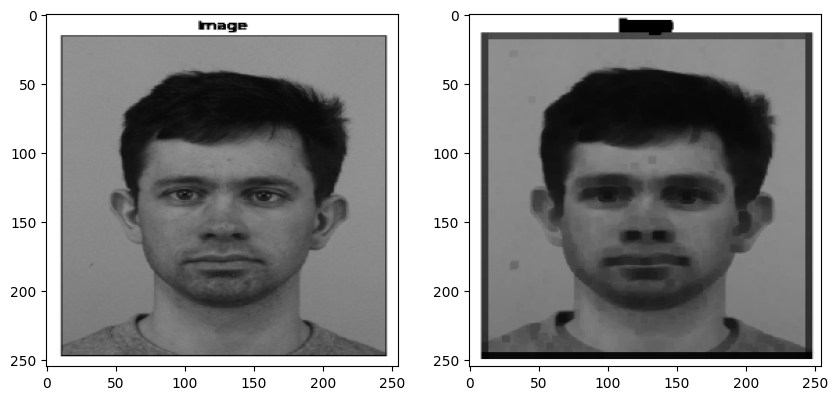

In [44]:
kernel = np.ones((5,5),np.uint8)
erosion = cv.erode(img_o,kernel,iterations=1)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 5))
ax0.imshow(img, cmap='gray');
ax1.imshow(erosion, cmap='gray');


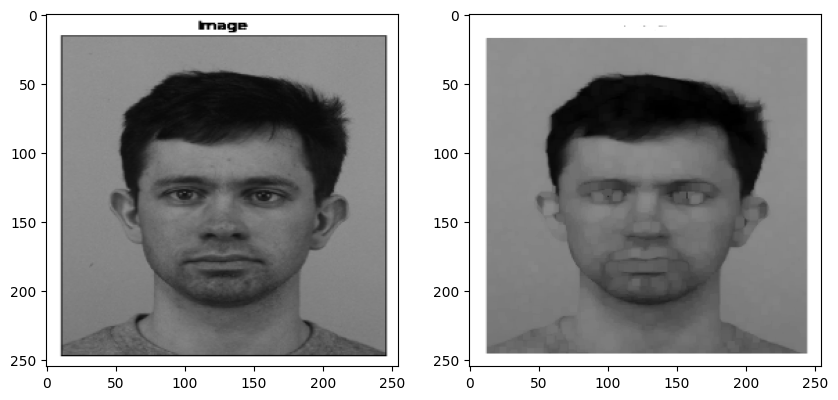

In [45]:
kernel = np.ones((5,5),np.uint8)
erosion = cv.dilate(img_o,kernel,iterations=1)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 5))
ax0.imshow(img, cmap='gray');
ax1.imshow(erosion, cmap='gray');


## References
1.
https://scikit-image.org/skimage-tutorials/lectures/1_image_filters.html
2.
https://github.com/m4nv1r/medium_articles/blob/master/Image_Filters_in_Python.ipynb

5.
https://youtu.be/Fdhn5_gT1wY

6.
https://staff.fnwi.uva.nl/r.vandenboomgaard/IPCV20172018/LectureNotes/IP/LocalOperators/bilateralfilter.html